In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image

In [75]:
# import the datasets
train_dir = "./dataset/train"
test_dir = "./dataset/test"

Emotions = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', "Surprised"]

In [88]:
import hashlib
import os
from PIL import Image
import cv2

# # Check for duplicates and remove
# def remove_duplicates(duplicates):
#     for duplicate, original in duplicates:
#         os.remove(duplicate)  # Remove the duplicate file

# def hash_image(image_path):
#     with Image.open(image_path) as img:
#         hash_value = hashlib.md5(img.tobytes()).hexdigest()
#     return hash_value

# def find_duplicates(directory):
#     hash_dict = {}
#     duplicates = []
#     for subdir, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             file_hash = hash_image(file_path)
#             if file_hash in hash_dict:
#                 duplicates.append((file_path, hash_dict[file_hash]))
#             else:
#                 hash_dict[file_hash] = file_path
#     return duplicates

# duplicates = find_duplicates(train_dir)
# print(f"Found {len(duplicates)} duplicate images.")

# remove_duplicates(duplicates)

# train_dir = "./dataset/train"
# test_dir = "./dataset/test"

In [ ]:
# def equalize_histogram(image):
#     try:
#         if len(image.shape) == 3:
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         equalized_image = cv2.equalizeHist(image)
#         return equalized_image
#     except Exception as e:
#         print(f"Error during histogram equalization: {e}")
#         return None

# def process_images_in_directory(input_dir, output_dir):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
    
#     for filename in os.listdir(input_dir):
#         print(f"Processing file: {filename}")  # Debugging line
#         if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#             img_path = os.path.join(input_dir, filename)
#             print(f"Reading image: {img_path}")  # Debugging line
#             image = cv2.imread(img_path)
#             if image is None:
#                 print(f"Error loading image: {img_path}")
#                 continue
            
#             equalized_image = equalize_histogram(image)
            
#             if equalized_image is not None:
#                 output_path = os.path.join(output_dir, filename)
#                 cv2.imwrite(output_path, equalized_image)
#                 print(f"Image saved: {output_path}")  # Debugging line
#             else:
#                 print(f"Error equalizing image: {img_path}")
#         else:
#             print(f"Skipping file (not an image): {filename}")  # Debugging line

# process_images_in_directory('./dataset/train/angry' , './dataset/train_edited/angry')
# process_images_in_directory('./dataset/train/disgusted' , './dataset/train_edited/disgusted')
# process_images_in_directory('./dataset/train/fearful' , './dataset/train_edited/fearful')
# process_images_in_directory('./dataset/train/happy' , './dataset/train_edited/happy')
# process_images_in_directory('./dataset/train/neutral' , './dataset/train_edited/neutral')
# process_images_in_directory('./dataset/train/sad' , './dataset/train_edited/sad')
# process_images_in_directory('./dataset/train/surprised' , './dataset/train_edited/surprised')

# process_images_in_directory('./dataset/test/angry' , './dataset/test_edited/angry')
# process_images_in_directory('./dataset/test/disgusted' , './dataset/test_edited/disgusted')
# process_images_in_directory('./dataset/test/fearful' , './dataset/test_edited/fearful')
# process_images_in_directory('./dataset/test/happy' , './dataset/test_edited/happy')
# process_images_in_directory('./dataset/test/neutral' , './dataset/test_edited/neutral')
# process_images_in_directory('./dataset/test/sad' , './dataset/test_edited/sad')
# process_images_in_directory('./dataset/test/surprised' , './dataset/test_edited/surprised')

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split = 0.25,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25)

train_generator = train_datagen.flow_from_directory(directory = './dataset/train_edited',
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    shuffle  = True, 
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed=12)

validation_generator = test_datagen.flow_from_directory(directory = './dataset/train_edited',
                                                        target_size = (48,48),
                                                        batch_size = 64,
                                                        shuffle  = False, 
                                                        color_mode = "grayscale",
                                                        class_mode = "categorical",
                                                        subset = "validation",
                                                        seed=12)

test_generator = test_datagen.flow_from_directory(directory = './dataset/test_edited',
                                                  target_size = (48,48),
                                                  batch_size = 64,
                                                  shuffle  = False, 
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical",
                                                  seed=12)

Found 20606 images belonging to 7 classes.
Found 6867 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


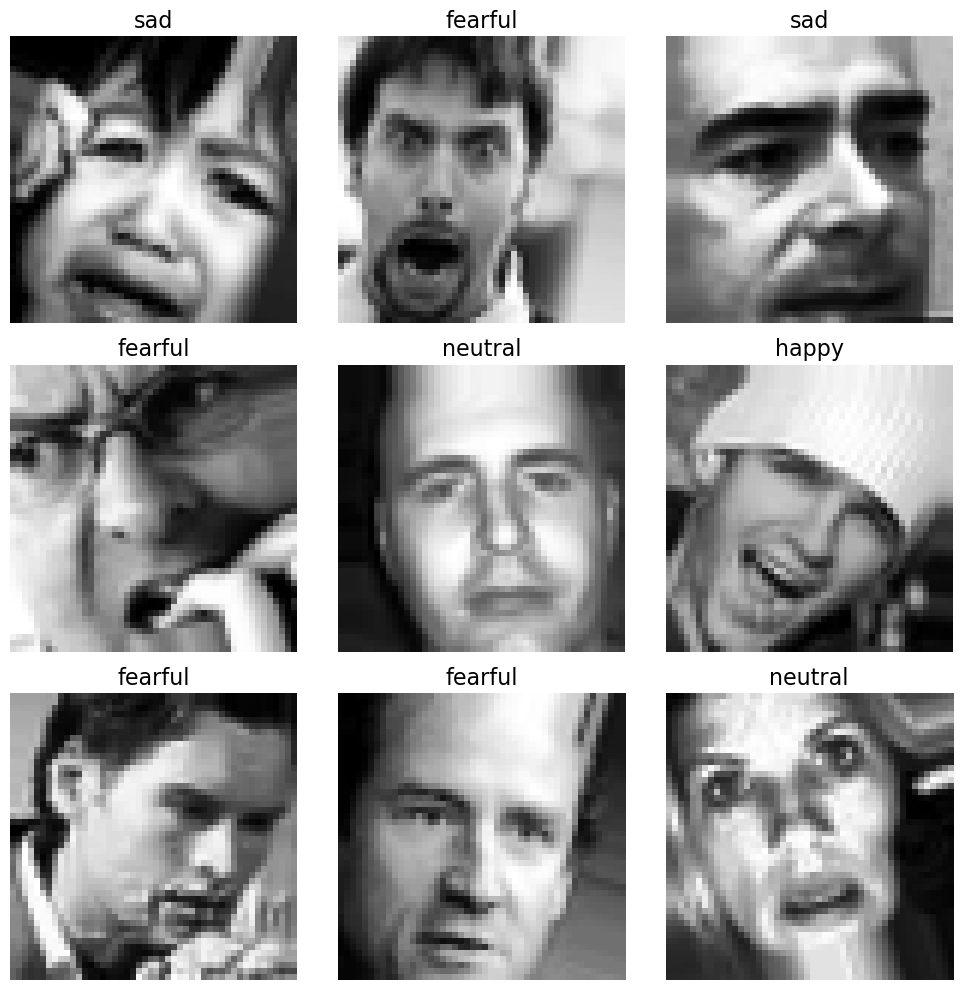

In [78]:
# Function to plot images
def display_images_with_labels(images, labels, class_labels):
    # Convert labels to class names
    class_indices = np.argmax(labels, axis=-1)  # Get class indices from one-hot labels
    titles = [class_labels[idx] for idx in class_indices]  # Convert indices to class names
    
    # Plot 9 images in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, title, ax in zip(images[:9], titles[:9], axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
        ax.set_title(title, fontsize=16)
        ax.axis('off')  # Hide axis
        
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images and labels
images, labels = next(train_generator)

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Display 9 images with labels
display_images_with_labels(images, labels, class_labels)

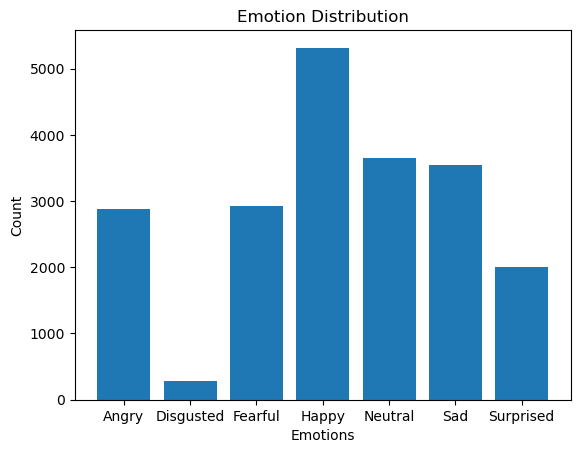

In [79]:
# class distribution
plt.bar(Emotions, [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)])
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

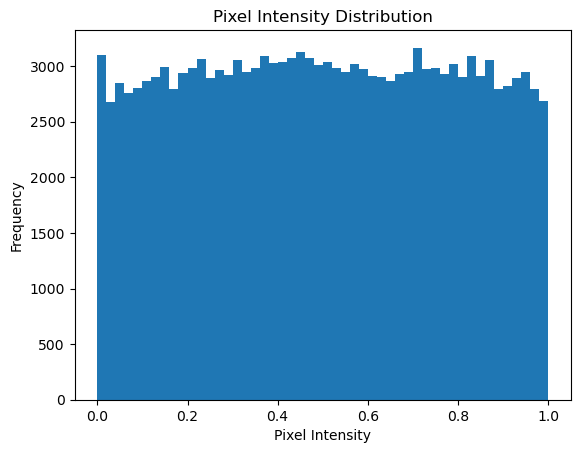

Mean pixel intensity: 0.49996253848075867
Standard deviation of pixel intensity: 0.28603360056877136


In [80]:
image_flat = images.flatten()
plt.hist(image_flat, bins=50)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

mean = np.mean(images)
std_dev = np.std(images)

print(f'Mean pixel intensity: {mean}')
print(f'Standard deviation of pixel intensity: {std_dev}')

In [81]:
from sklearn.utils.class_weight import compute_class_weight

# balance the class distribution using weights
classes = np.unique(train_generator.classes)
y = train_generator.classes
class_weights = compute_class_weight('balanced', classes=classes, y=y)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

class_weights_gen = {0: 1.0, 1: 6.0, 2: 1.0, 3: 0.6, 4: 0.8, 5: 0.8, 6: 1.0}

{0: 1.0196447127517443, 1: 10.292707292707293, 2: 1.005366900858704, 3: 0.5538502889396586, 4: 0.8062761669992565, 5: 0.8322630154691223, 6: 1.4703867561010417}


In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# build CNN model
model = Sequential()

model.add(Conv2D(32,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       524,80

 Total params: 1,187,463 (4.53 MB)

 Trainable params: 1,183,431 (4.51 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [83]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5,
                                                        verbose=1,
                                                        restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

epochs = 50

history = model.fit(
    x=train_generator,
    epochs=epochs,
    class_weight = class_weights_gen,
    validation_data = validation_generator,
    callbacks= [earlyStoppingCallback, lr_schedule])

history = pd.DataFrame(history.history)

Epoch 1/50


c:\Users\Piper\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.1936 - loss: 3.0827 - val_accuracy: 0.1421 - val_loss: 3.1358 - learning_rate: 5.0000e-04
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.2850 - loss: 2.5758 - val_accuracy: 0.3887 - val_loss: 2.3728 - learning_rate: 5.0000e-04
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.3393 - loss: 2.3552 - val_accuracy: 0.3858 - val_loss: 2.3111 - learning_rate: 5.0000e-04
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - accuracy: 0.3745 - loss: 2.1725 - val_accuracy: 0.4251 - val_loss: 2.1232 - learning_rate: 5.0000e-04
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.4054 - loss: 1.9876 - val_accuracy: 0.3789 - val_loss: 2.1361 - learning_rate: 5.0000e-04
Epoch 6/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.4277 - loss: 1.8442 - val_accuracy: 0.3897 - val_loss: 1.9794 - learning_rate: 5.0000e-04
Epoch 7/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - 

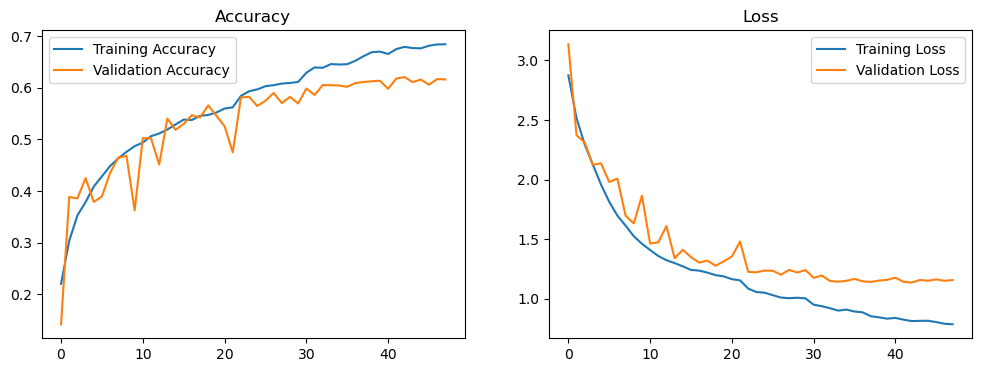

In [84]:
# plot training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step


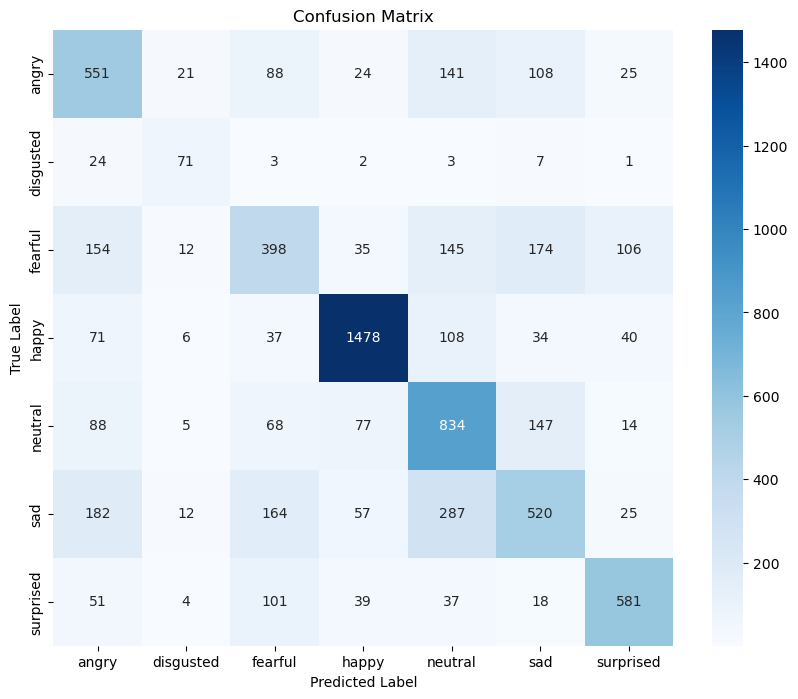

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# retrieve predicted values
y_pred_probs = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# extract class labels
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [86]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, y_pred, target_names=validation_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

       angry       0.49      0.58      0.53       958
   disgusted       0.54      0.64      0.59       111
     fearful       0.46      0.39      0.42      1024
       happy       0.86      0.83      0.85      1774
     neutral       0.54      0.68      0.60      1233
         sad       0.52      0.42      0.46      1247
   surprised       0.73      0.70      0.72       831

    accuracy                           0.62      7178
   macro avg       0.59      0.60      0.59      7178
weighted avg       0.62      0.62      0.62      7178



(-0.5, 47.5, 47.5, -0.5)

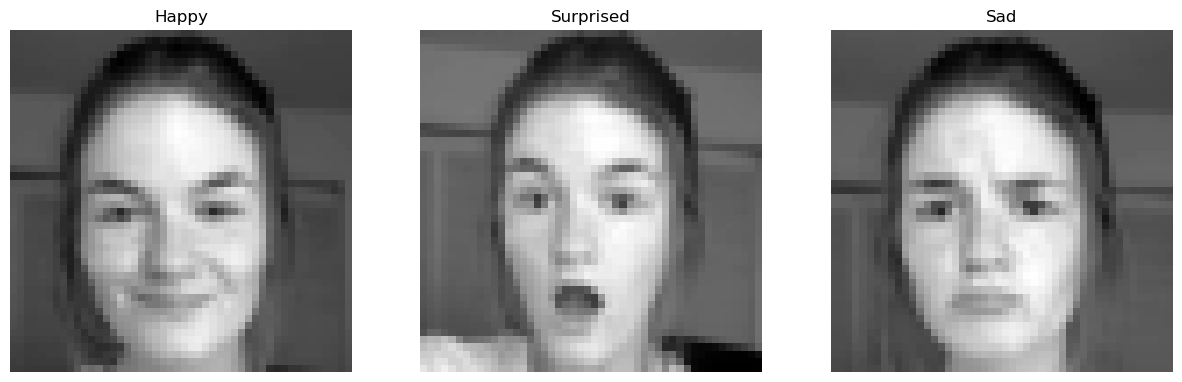

In [150]:
import cv2

def preprocess_image(pil_image):
    image = np.array(pil_image)
    if len(image.shape) == 3:  # Convert to grayscale if image is RGB
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    normalized_image = np.array(image, dtype='float32') / 255.0  # Normalize

    normalized_image = np.expand_dims(normalized_image, axis=-1)

    return normalized_image

# testing with self-made images
img1_happy = Image.open("./self-made/IMG_4204.png")
img2_surprised = Image.open("./self-made/IMG_4205.png")
img3_sad = Image.open("./self-made/IMG_4206.png")

img1_smallHappy = img1_happy.resize((48,48), resample=Image.Resampling.BILINEAR)
img2_smallSurprised = img2_surprised.resize((48,48), resample=Image.Resampling.BILINEAR)
img3_smallSad = img3_sad.resize((48,48), resample=Image.Resampling.BILINEAR)

image1 = preprocess_image(img1_smallHappy)
image2 = preprocess_image(img2_smallSurprised)
image3 = preprocess_image(img3_smallSad)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Happy')
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Surprised')
axes[1].axis('off')

axes[2].imshow(image3, cmap='gray')
axes[2].set_title('Sad')
axes[2].axis('off')


In [158]:
predictions = model.predict(np.expand_dims(image1, axis=0))  # Add batch dimension
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class label: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class label: happy
Predicted class index: 3
